In [141]:
import os
import glob
import re

import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from scipy.spatial.distance import cdist

import MDAnalysis
from MDAnalysis.analysis.rms import RMSD

import matplotlib.pyplot as plt

from tqdm import tqdm

# Protein Bioinformatics - Day 3

## Protein - Ligand Interaction
Study the interaction of the protein with the ligand and answer the following questions. The simulation only covers a 10 $ \mathring{A}$ zone around the substrate to simplify the calculations.

1. Which one is the protein in the molecular dynamic?
2. What is the catalytic activity and how does it relate to the ligand we have?
3. Is the interaction with the ligand stable over time?
4. hat is the distance to the main catalytics residue?
5. Do you think catalysis would happen based on this MD?

## Peptide Analysis

Study the evolution over time of three example peptides. The heptapeptides have the following sequence: **AXAHAXA**. In table below, you have the equivalency between the **X** position and the catalytic activity ot the peptide on the reduction of acetophone.

 X | Turnover Frequency ($h^{-1}$)| Conversion (%)          |
:-:|-----------------------------:|------------------------:|
 F | 24                           | 94                      |
 Y | 30                           | 96                      |
 K |  9                           | 81                      |
 D | 17                           | 80                      |
 
 ---
 Analyse the dynamics and answer the following question:
 1. How do the different peptides behave over time? Is there a stable structure or a secondary structure forming?
 *The stability of the peptides depends of the RMSD threshold we choose. If we take a threshold value of 2 $\mathring{A}$, which seems standard according to the litterature, none of the protein is stable. To study the stability we also tried studying the existence of clusters in the trajectories. To do so, we built a tensor of the $\alpha$-carbons positions using the Kabsch transform to remove the variation due to protein translation and rotation in the medium. We then used k-means clustering to identify clusters of structures during the trajectories. To optimize the number of clusters, we minimized the C-Index (computed with RMSD as distance measure) for $k$ between $5$ and $20$. With such analysis, we obtained that Asp had 25 frames where the protein was in the most common configuration, Lys had 28 frames, Phe had 44 frames and Tyr had 31 frames. For visualisation purpose, we used a PCA which show that the clustering works.*
 
 2. Take a snapshot of the centroid of each peptide and compare them.
 *To obtain the centroid of each peptide, we ran the RMSD taking as reference input each frames. We always obtained that the centroid was the initial peptide.*
 
 3. Can you find any parameter that relates to the turnover frequency? And the conversion?
 *We did not find any parameters related to these values. Molecular Dynamics does not aim to simulate reaction at the electronic level and thus we cannot study the reduction of acetophone.*


In [24]:
def files_from_dcd_dir(dcd_dir):
    if not isinstance(dcd_dir, str):
        raise NotImplementedError()
        
    pdb = os.path.join(dcd_dir, "peptide.pdb")
    if not os.path.isfile(pdb):
        raise FileNotFoundError()
        
    dcd = os.path.join(dcd_dir, "output.dcd")
    if not os.path.isfile(dcd):
        raise FileNotFoundError() 
        
    return pdb, dcd
    
def get_rmsd_from_dcd(dcd_dir):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_rmsd_from_dcd(el) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()

    pdb, dcd = files_from_dcd_dir(dcd_dir)
    u = MDAnalysis.Universe(pdb, dcd)
    ref = u.copy()
    
    R = RMSD(u, ref, select="backbone and name CA")
    R.run()
    
    re_name = r".*\/(?P<name>.*)\/$"
    match = re.match(re_name, dcd_dir).groupdict()
    name = match['name']
    
    rmsd = R.results.rmsd.T
    
    return name, rmsd

def get_centroid_from_dcd(dcd_dir):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_centroid_from_dcd(el) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()
        
    pdb, dcd = files_from_dcd_dir(dcd_dir)
    u = MDAnalysis.Universe(pdb, dcd)
    ref = u.copy()
    
    distances = np.empty((len(ref.trajectory), len(ref.trajectory)))
    for i, ts in tqdm(enumerate(ref.trajectory)):
        R = RMSD(u, ref, select="backbone and name CA")
        R.run()
        
        distances[i, :] = R.results.rmsd.T[2, :]
        
    similarity_scores = np.exp(- distances / np.std(distances))
    indices = np.sum(similarity_scores, axis=1)
    centroid_index = np.argmax(indices)
    
    return centroid_index        

def plot_rmsd(rmsd, ax=None, row_length=2):
    if isinstance(rmsd, list):
        n_el = len(rmsd)
        fig, axes = plt.subplots(n_el // row_length, row_length)
        fig.tight_layout(pad=3.0)
        for i, el in enumerate(rmsd):
            plot_rmsd(el, axes[i // row_length, i % row_length]) 
        return
            
    elif not isinstance(rmsd[0], str) and \
         not isinstance(rmsd[1], np.ndarray):
        raise NotImplementedError()
        
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        
    ax.plot(rmsd[1][1], rmsd[1][2])
    ax.set_title(rmsd[0])
    ax.set_ylim(-.1, 6)

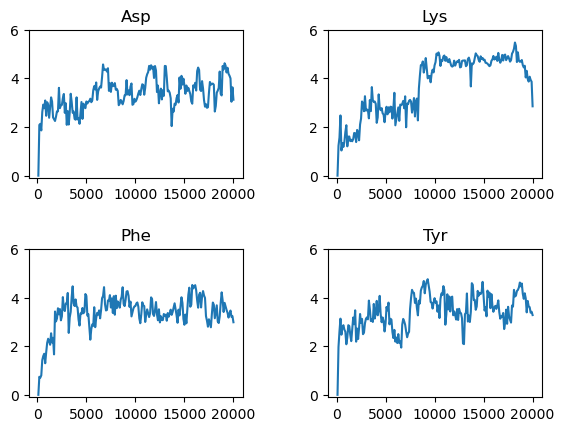

In [3]:
dcds = glob.glob("./peptide-analysis/*/")
rmsds = get_rmsd_from_dcd(dcds)
plot_rmsd(rmsds)

In [27]:
centroid = get_centroid_from_dcd(dcds)
centroid

200it [00:40,  5.00it/s]
200it [00:41,  4.78it/s]
200it [00:40,  4.91it/s]
200it [00:42,  4.73it/s]


[0, 0, 0, 0]

### Clustering of Trajectories using K-Means and Kabsch Transform

In [144]:
def kabsch_transform(mol1, mol2):
    if mol1.shape[0] != 3 and mol2.shape[0] != 3:
        raise ValueError()
    if mol1.shape[1] != mol2.shape[1]:
        raise ValueError()
        
    mol1_c = np.mean(mol1, axis=1, keepdims=True)
    mol2_c = np.mean(mol2, axis=1, keepdims=True)
    mol1_m = mol1 - mol1_c
    mol2_m = mol2 - mol2_c
    
    A = mol2_m @ mol1_m.T
    U2, S, U1t = np.linalg.svd(A)
    
    d = np.sign(np.linalg.det(U2 @ U1t))
    R = (U2 @ np.diag([1., 1., d])) @ U1t
    t = mol2_c - R @ mol1_c
    
    mol1_updated = (R @ mol1 + t).T
    return mol1_updated

def get_tensor_from_dcd(dcd_dir):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_tensor_from_dcd(el) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()
        
    pdb, dcd = files_from_dcd_dir(dcd_dir)
    u = MDAnalysis.Universe(pdb, dcd)
    
    # Frame 0 coordinates
    CAs_0 = u.atoms.select_atoms("backbone and name CA")
    CAs_0 = np.array([el.position for el in CAs_0])
    
    # Compute average using Kabsch transform to mitigage protein
    # rotation and translation
    CAs_tensor = np.zeros((CAs_0.shape[0], CAs_0.shape[1], len(u.trajectory)))

    for i, ts in enumerate(u.trajectory):
        CAs = u.atoms.select_atoms("backbone and name CA")
        CAs = np.array([el.position for el in CAs])   
        CAs = kabsch_transform(CAs.T, CAs_0.T)

        CAs_tensor[:,:,i] = CAs
        
    return CAs_tensor

def get_average_form_dcd(dcd_dir):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_average_form_dcd(el) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()
        
    CAs_tensor = get_tensor_from_dcd(dcd_dir)
    CAs_avg = np.mean(CAs_tensor, axis=2)
    
    CAs_avg = CAs_avg - np.mean(CAs_avg, axis=0, keepdims=True)
    return CAs_avg

def get_median_from_dcd(dcd_dir):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_average_form_dcd(el) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()
        
    CAs_tensor = get_tensor_from_dcd(dcd_dir)
    CAs_avg = np.mean(CAs_tensor, axis=2)
    
    CAs_avg = CAs_avg - np.median(CAs_avg, axis=0, keepdims=True)
    return CAs_avg

def get_clusters_from_dcd(dcd_dir, init="random", n_clusters=4, n_init=4, random_state=0, min_clusters=2, max_clusters=15):
    if isinstance(dcd_dir, (tuple, list)):
        return [get_clusters_from_dcd(el, init, n_clusters, n_init, random_state, min_clusters, max_clusters) for el in dcd_dir]
    elif not isinstance(dcd_dir, str):
        raise NotImplementedError()
    
    CAs_tensor = get_tensor_from_dcd(dcd_dir)
    
    # C-Index optimization
    c_indices = []
    if not n_clusters:
        best_clusters = None
        best_labels = None
        best_c_index = np.infty
        for n in tqdm(range(min_clusters, max_clusters)):
            CAs_clusters, CAs_labels = get_clusters_from_dcd(dcd_dir, init, n, n_init, random_state)
            c_index = get_c_index(CAs_clusters, CAs_labels, CAs_tensor)
            c_indices += [c_index]
            if c_index < best_c_index:
                best_clusters = CAs_clusters
                best_labels = CAs_labels
                best_c_index = c_index
                
        return best_clusters, best_labels, c_indices
            
    CAs_data = np.reshape(CAs_tensor, (CAs_tensor.shape[2], CAs_tensor.shape[0], CAs_tensor.shape[1]))
    CAs_data = np.reshape(CAs_data, (CAs_data.shape[0], CAs_data.shape[1]*CAs_data.shape[2]))

    kmeans = KMeans(init=init, n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    kmeans.fit_transform(CAs_data)
    
    CAs_clusters = kmeans.cluster_centers_
    CAs_clusters = np.reshape(CAs_clusters, (CAs_clusters.shape[1], n_clusters))
    CAs_clusters = np.reshape(CAs_clusters, (CAs_tensor.shape[0], CAs_tensor.shape[1], n_clusters))
    
    CAs_labels = kmeans.labels_
    return CAs_clusters, CAs_labels

def get_c_index(clusters, labels, tensor):
    Gamma = 0
    for i in range(len(labels) - 1):
        for j in range(i+1, len(labels)):
            if labels[i] == labels[j]:
                Gamma += _rmsd_(tensor[:, :, i], tensor[:, :, j])
                
    alphas = [np.sum([1 for el in labels if el == label]) for label in np.unique(labels)]
    
    C = (Gamma - np.min(alphas)) / (np.max(alphas) - np.min(alphas))
    return C  

def _rmsd_(mol1, mol2):
    if not mol1.shape == mol2.shape:
        raise NotImplementedError()
        
    val = np.subtract(mol1, mol2)
    val = np.sum(np.power(val, 2), axis=1)
    val = np.sum(val.shape[0]) / val.shape[0]
    val = np.power(val, .5)
    return val

def get_most_common_cluster(clusters, labels, *args):
    unique, counts = np.unique(labels, return_counts=True)
    most_common_label = unique[np.argmax(counts)]

    return clusters[:, :, most_common_label], np.max(counts)

def plot_clusters(CAs_labels, CAs_tensor):
    CAs_data = np.reshape(CAs_tensor, (CAs_tensor.shape[2], CAs_tensor.shape[0], CAs_tensor.shape[1]))
    CAs_data = np.reshape(CAs_data, (CAs_data.shape[0], CAs_data.shape[1]*CAs_data.shape[2]))

    pca = PCA(n_components=2)
    #pca = KernelPCA(n_components=2, kernel="rbf")
    
    CAs_pca = pca.fit_transform(CAs_data)
    plt.scatter(CAs_pca[:, 0], CAs_pca[:, 1], c=CAs_labels)


In [5]:
tensors_lst = get_tensor_from_dcd(dcds)
clusters_lst = get_clusters_from_dcd(dcds, n_clusters=0, min_clusters=5, max_clusters=20)
most_common_clusters =  [get_most_common_cluster(el[0], el[1]) for el in clusters_lst]

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


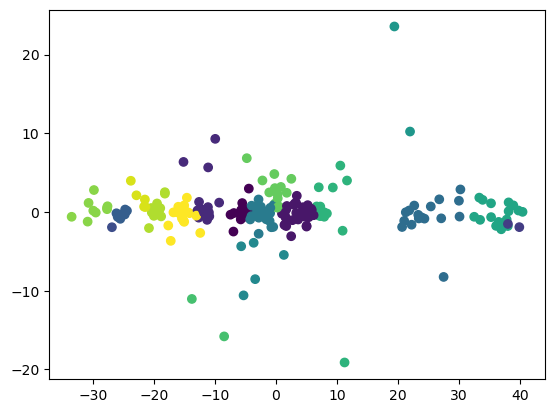

In [149]:
peptide = 3
plot_clusters(clusters_lst[peptide][1], tensors_lst[peptide])